### TC4034.10 Análisis de grandes volúmenes de datos

#### Equipo 13


* Hansel Zapiain Rodríguez (A00469031)
* Miguel Guillermo Galindo Orozco (A01793695)
* Francisco José Arellano Montes (A01794283)

**4.3 Avance de proyecto 1: Sistema de Recomendación**
   
Mayo 2024

**Objetivos**


El desarrollo de esta actividad contribuye al cumplimiento del objetivo del Modulo 2:

Identificar las diferentes plataformas de Big Data Analytics y sus características para el manejo de tareas de procesamiento de datos a gran escala.


**Instrucciones**

En esta entrega es necesario realizar un reporte donde se enlisten los siguientes aspectos:
Genera un plan de proyecto de acuerdo con la industria elegida por tu equipo en la actividad 2.2 y detalla el plan del proyecto con su cronograma.
Justifica la selección del conjunto de datos utilizado y describe los pasos de preprocesamiento.
Realiza al menos un ejercicio de exploración inicial y análisis del conjunto de datos de la industria elegida (la evidencia se debe pone en el repositorio GitHub del equipo). Programa al menos un 1 algoritmo de recomendación básico con el conjunto de datos elegido (la evidencia se debe pone en el repositorio GitHub del equipo).

## Importar Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import itertools
import matplotlib.pyplot as plt

from datasets import load_dataset
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

In [2]:
dataset = load_dataset('McAuley-Lab/Amazon-Reviews-2023', 'raw_review_All_Beauty', download_mode = 'force_redownload')

C:\Users\hzapi\anaconda3\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for McAuley-Lab/Amazon-Reviews-2023 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/McAuley-Lab/Amazon-Reviews-2023
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating full split:   0%|          | 0/701528 [00:00<?, ? examples/s]

In [3]:
df_amz = dataset['full'].to_pandas()
df_amz.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


## Exploración de Datos

In [4]:
df_amz.shape

(701528, 10)

In [5]:
df_amz.describe()

,rating,timestamp,helpful_vote
count,701528.000000,7.015280e+05,701528.000000
mean,3.960245,1.554781e+12,0.923588
std,1.494452,8.005792e+10,5.471391
min,1.000000,9.730527e+11,0.000000
25%,3.000000,1.501616e+12,0.000000
50%,5.000000,1.571595e+12,0.000000
75%,5.000000,1.614647e+12,1.000000
max,5.000000,1.694220e+12,646.000000


In [6]:
missing_percentage_per_column_sales = (df_amz.isnull().mean() * 100).round(2)
print("Presencia de datos faltantes por dimensión (en porcentaje):")
print(missing_percentage_per_column_sales)

Presencia de datos faltantes por dimensión (en porcentaje):
rating               0.0
title                0.0
text                 0.0
images               0.0
asin                 0.0
parent_asin          0.0
user_id              0.0
timestamp            0.0
helpful_vote         0.0
verified_purchase    0.0
dtype: float64


In [7]:
n_users = df_amz.user_id.nunique()
n_items = df_amz.asin.nunique()

print('No. Usuarios: '+ str(n_users))
print('No. ASINs: '+str(n_items))

No. Usuarios: 631986
No. ASINs: 115709


In [8]:
print("El Data Set a estudiar cuenta con " + str(len(df_amz)) + " registros de rating de productos adquiridos en Amazon")

El Data Set a estudiar cuenta con 701528 registros de rating de productos adquiridos en Amazon


Veamos los productos que más veces fue evaludado (con más reseñas) 

In [9]:
df_amz.groupby('asin')['rating'].count().sort_values(ascending = False).head(10)

asin
B007IAE5WY    1962
B00EEN2HCS    1750
B07C533XCW    1513
B00R1TAN7I    1372
B08L5KN7X4    1343
B019GBG0IE    1328
B0719KWG8H    1168
B0092MCQZ4    1128
B0107QYW14    1112
B0070Z7KME     934
Name: rating, dtype: int64

Observamos ahora cuál es el rating promedio de los productos con más evaluaciones

In [10]:
ratings = pd.DataFrame(df_amz.groupby('asin')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df_amz.groupby('asin')['rating'].count())
ratings.sort_values(by = 'num of ratings', ascending = False).head(100)

,rating,num of ratings
asin,,
B007IAE5WY,4.620285,1962
B00EEN2HCS,4.135429,1750
B07C533XCW,4.468605,1513
B00R1TAN7I,4.033528,1372
B08L5KN7X4,4.015637,1343
...,...,...
B07DMD8M5T,4.003215,311
B078J32XBK,3.874194,310
B0067BAIM6,4.575163,306


In [11]:
print('Existen ' + str(len(ratings[ratings['num of ratings']>=300])) + ' productos con al menos 300 evaluaciones')

Existen 105 productos con al menos 300 evaluaciones


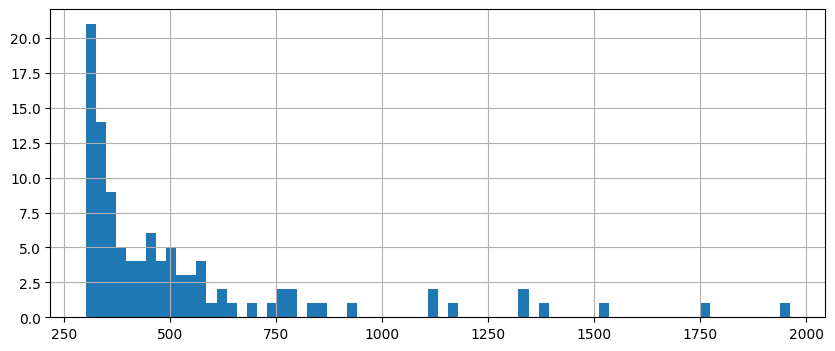

In [12]:
plt.figure(figsize = (10,4))
ratings[ratings['num of ratings']>300]['num of ratings'].hist(bins = 70)
plt.show()

La distribución de los ratings observados se ve de la siguiente forma

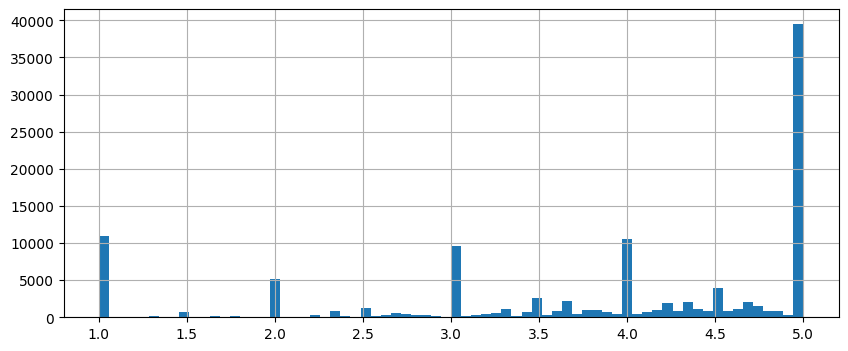

In [13]:
plt.figure(figsize = (10,4))
ratings['rating'].hist(bins = 70)
plt.show()

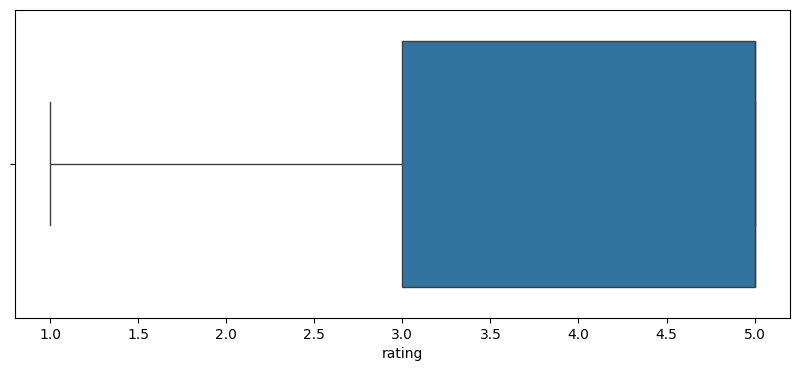

In [14]:
plt.figure(figsize = (10,4))
sns.boxplot(x = df_amz['rating'])
plt.show()

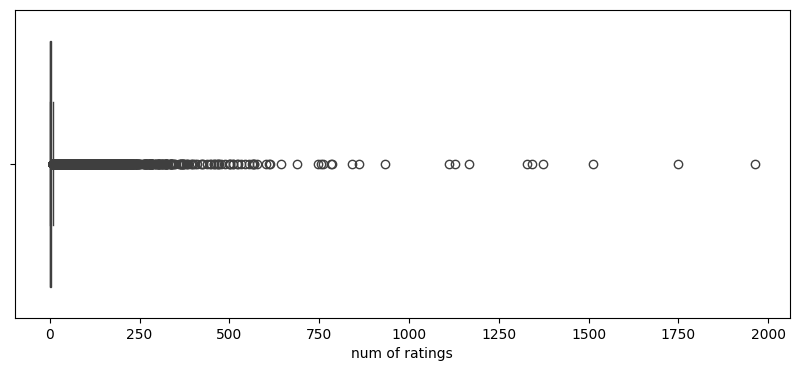

In [15]:
plt.figure(figsize = (10,4))
sns.boxplot(x = ratings['num of ratings'])
plt.show()

Mientras que para aquellos que tienen más de 300 evaluaciones se ve así

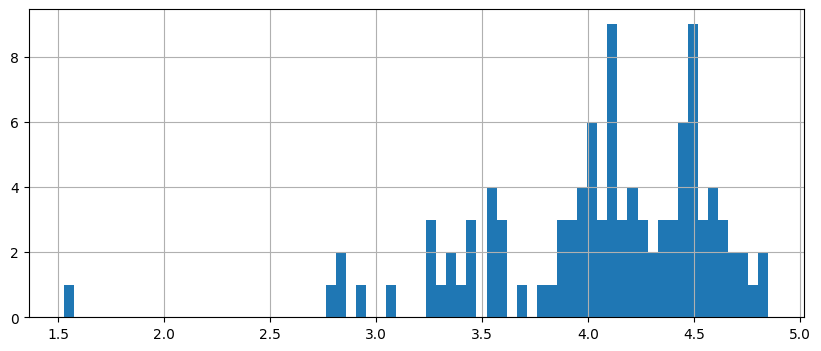

In [16]:
plt.figure(figsize = (10,4))
ratings[ratings['num of ratings']>300]['rating'].hist(bins=70)
plt.show()

Se observa que en general la mayoría de los productos con más de 300 evaluaciones tienen ratings por arriba de 3 / 3.5 de calificacación

Mientras que para los que tienen menos de 300 evaluaciones se ve así: 

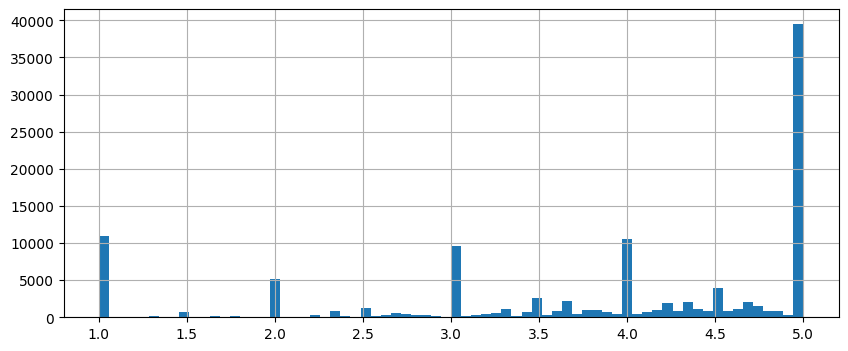

In [17]:
plt.figure(figsize = (10,4))
ratings[ratings['num of ratings']<300]['rating'].hist(bins = 70)
plt.show()

<Axes: xlabel='rating'>

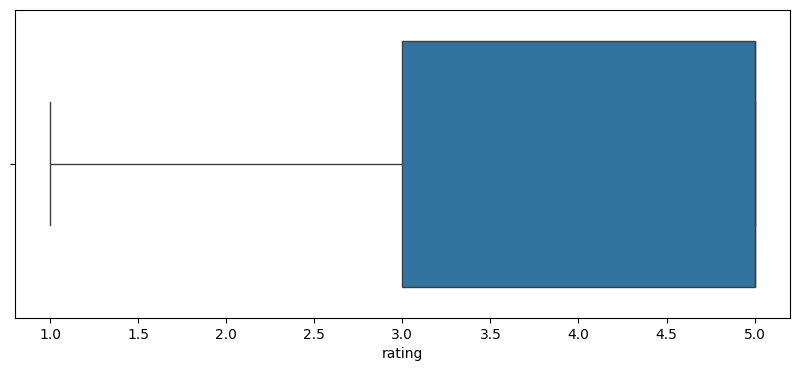

In [18]:
plt.figure(figsize=(10,4))
sns.boxplot(x = df_amz['rating'])

<Figure size 1000x400 with 0 Axes>

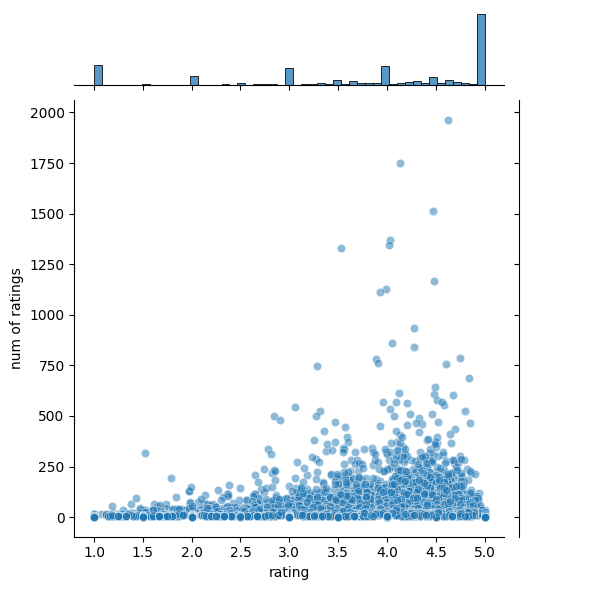

In [19]:
plt.figure(figsize = (10,4))
sns.jointplot(x = 'rating', y = 'num of ratings', data = ratings, alpha = 0.5)
plt.show()

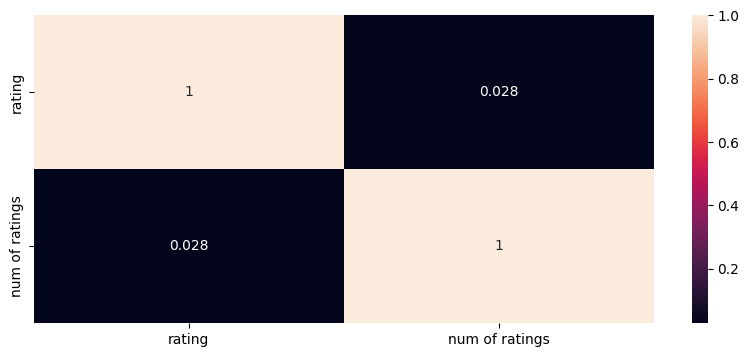

In [20]:
plt.figure(figsize = (10,4))
num_corr_matrix = ratings.corr()
ax = sns.heatmap(num_corr_matrix, annot = True)
plt.show()

## Memory-Based Collaborative Filtering (Tradicional)

Los enfoques de filtrado colaborativo basado en memoria se pueden dividir en dos secciones principales: filtrado usuario-artículo y filtrado artículo-artículo.Un filtrado usuario-usuario tomará un usuario en particular, encontrará usuarios que sean similares a ese usuario basándose en la similitud de las calificaciones y recomendará artículos que esos usuarios similares hayan gustado. En contraste, el filtrado artículo-artículo tomará un artículo, encontrará usuarios a los que les haya gustado ese artículo y encontrará otros artículos que esos usuarios o usuarios similares también hayan gustado. Toma artículos y proporciona otros artículos como recomendaciones.

Filtrado Colaborativo Artículo-Artículo: “A los usuarios que les gustó este Artículos también les gustó…”

Filtrado Colaborativo Usuario-Artículo: “A los usuarios que son similares a ti también les gustó…”

En ambos caso, se crea una matriz usuario-artículo del dataset completo.

Una métrica de distancia comúnmente utilizada en los sistemas de recomendación es la similitud del coseno, donde las calificaciones se ven como vectores en un espacio de n dimensiones y la similitud se calcula en función del ángulo entre estos vectores. La similitud del coseno para los usuarios a y m se puede calcular utilizando la fórmula a continuación, donde se toma el producto punto del vector de usuario $u_k$ y el vector de usuario $u_a$ y se divide por la multiplicación de las longitudes euclidianas de los vectores.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>


Para calcular la similitud entre los artículos m y b se utiliza la fórmula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Dado que la matriz original [631986 x 115709] (todos los usuarios por todos los articulos), requiere altos niveles de computo utilizaremos una versión reducida para demostrar como funciona un modelo de recomendación normal.

In [21]:
df_amz_red = df_amz[['user_id','asin','rating']].copy()

In [22]:
df_sample = df_amz_red.sample(frac = 0.05, replace=False, random_state = 1234)

In [23]:
train_data, test_data = train_test_split(df_sample, test_size = 0.25)

In [24]:
for line in itertools.islice(train_data.itertuples(), 5):
    print(line)

Pandas(Index=510686, user_id='AFHE4JKFOUFC2UXJPS3MLBXBYK6Q', asin='B07Q6R1119', rating=5.0)
Pandas(Index=185118, user_id='AGHARDL7VX2E54JV5MKYYKMFJIKA', asin='B07NY6619X', rating=1.0)
Pandas(Index=264827, user_id='AGNUXFQ5L2YHYHBJVOTVQKCX6ZWA', asin='B089DQTSFB', rating=5.0)
Pandas(Index=329943, user_id='AEGJUIBRMHJIR3J7JRWALK7S23FA', asin='B08R1BWJ8F', rating=5.0)
Pandas(Index=315146, user_id='AG3XOWH3GRMJK3CYLMYZIQNRS4CQ', asin='B01HOMLTYM', rating=4.0)


In [25]:
unique_users = train_data['user_id'].unique()
unique_items = train_data['asin'].unique()

n_users_red = len(unique_users)
n_items_red = len(unique_items)

user_to_index = {user_id: idx for idx, user_id in enumerate(unique_users)}
item_to_index = {item_id: idx for idx, item_id in enumerate(unique_items)}

In [26]:
train_data_matrix = np.zeros((n_users_red, n_items_red))
test_data_matrix = np.zeros((n_users_red, n_items_red))

for line in train_data.itertuples(index = False):
    user = user_to_index[line[train_data.columns.get_loc('user_id')]]
    item = item_to_index[line[train_data.columns.get_loc('asin')]]
    rating = float(line[train_data.columns.get_loc('rating')])
    train_data_matrix[user, item] = rating

for line in test_data.itertuples(index = False):
    user_id = line[test_data.columns.get_loc('user_id')]
    item_id = line[test_data.columns.get_loc('asin')]
    if user_id in user_to_index and item_id in item_to_index:
        user = user_to_index[user_id]
        item = item_to_index[item_id]
        rating = float(line[test_data.columns.get_loc('rating')])
        test_data_matrix[user, item] = rating

In [27]:
user_similarity = pairwise_distances(train_data_matrix, metric = 'cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric = 'cosine')

El siguiente paso es hacer predicciones. Con las matrices de similitud (user_similarity y item_similarity) por lo tanto se pueden hacer una predicción aplicando la siguiente fórmula para la filtración colaborativa basada en usuarios


<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

Se puede determinar la similitud entre los usuarios ky a como pesos que se multiplican por las calificaciones de un usuario similar a (corregido por la calificación promedio de ese usuario). Este se deberá de normalizar para que las calificaciones se mantengan entre 1 y 5 y, como paso final, sumar las calificaciones promedio para el usuario al que estás tratando de predecir.La idea aquí es que algunos usuarios pueden tender siempre a dar calificaciones altas o bajas a todos los artículos. 

La diferencia relativa en las calificaciones que estos usuarios dan es más importante que los valores absolutos. Para dar un ejemplo: supongamos que el usuario k da 4 estrellas a sus artículos favoritos y 3 estrellas al resto. Supongamos ahora que otro usuario t califica los artículos que le gustan con 5 estrellas, y los que no le gustaron con 3 estrellas. Estos dos usuarios podrían tener un gusto muy similar pero tratar el sistema de calificación de manera diferente. Al hacer una predicción para la filtración colaborativa basada en artículos no se necesita corregir la calificación promedio de los usuarios ya que el usuario de consulta en sí mismo se usa para hacer las predicciones.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [28]:
def predict(ratings, similarity, type = 'user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [29]:
item_prediction = predict(train_data_matrix, item_similarity, type = 'item')
user_prediction = predict(train_data_matrix, user_similarity, type = 'user')

Existen muchas métricas de evaluación, pero una de las métricas más populares utilizadas para evaluar la precisión de las calificaciones predichas es el Error Cuadrático Medio (RMSE).

<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

In [30]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [31]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 4.340807494452539
Item-based CF RMSE: 4.341074848191789


In [32]:
def get_top_n_recommendations(user_id, user_prediction, item_prediction, n = 10):
    if user_id not in user_to_index:
        return []
    
    user_idx = user_to_index[user_id]
    user_ratings = user_prediction[user_idx]
    item_ratings = item_prediction[:, user_idx]
    
    user_top_n_items = user_ratings.argsort()[-n:][::-1]
    item_top_n_items = item_ratings.argsort()[-n:][::-1]
    
    combined_top_n_items = np.unique(np.concatenate((user_top_n_items, item_top_n_items)))
    top_n_items = combined_top_n_items[:n] 
    
    index_to_item = {idx: item_id for item_id, idx in item_to_index.items()}
    top_n_item_ids = [index_to_item[idx] for idx in top_n_items]
    
    return top_n_item_ids

In [33]:
user_id = unique_users[0] 
top_n_recommendations = get_top_n_recommendations(user_id, user_prediction, item_prediction, n = 10)
print(f"Top 10 recommendations for user {user_id}: {top_n_recommendations}")

Top 10 recommendations for user AFHE4JKFOUFC2UXJPS3MLBXBYK6Q: ['B07C533XCW', 'B019GBG0IE', 'B08L5KN7X4', 'B0719KWG8H', 'B0092MCQZ4', 'B00R1TAN7I', 'B00EEN2HCS', 'B0107QYW14', 'B07X8W7GJZ', 'B007IAE5WY']
